In [30]:
"""
Controle de Pagamentos de Pessoal

Este sistema realiza a análise e processamento de dados de remuneração do sistema SIAPE, bases corporativas e arquivos de dados. Ele foi produzido pelo 
Ten-Cel. QOBM/Comb. Igor MUNIZ da Silva como produto do trabalho monográfico do Curso de Altos Estudos para Oficiais Combatentes do ano de 2023 (CAEO/Comb - 2023), 
realizado no Centro de Estudos de Política, Estratégia e Doutrina (CEPED) do Corpo de Bombeiros Militar do Distrito Federal

As variáveis e constantes definidas no início do código especificam os diretórios, mês de trabalho e constantes de validação necessários para o processamento dos dados.

O arquivo de dados de pagamento deve ser extraído do sistema DW SIAPE filtrando o mês que se deseja apurar.  Deve ser composto, pelo menos, pelos seguintes dados:
- Colunas de atributos: CPF SERVIDOR;VÍNCULO SERVIDOR;CARGO;NOME SERVIDOR;SITUAÇÃO FUNCIONAL;NÍVEL FUNÇÃO;AD TEMPO SERV;UORG;DIA OCOR INGR ÓRGÃO EV;MÊS;COD RUBRICA;RUBRICA;
SEQUENCIAL RUBRICA;PRAZO RUBRICA
- Colunas de métricas: RENDIM;DESCONTO


Os principais passos do código são os seguintes:

1. Extração das bases de dados (SIAPE, GECOPE, GEDEP, GSVWeb).
2. Formatação e validação dos dados, incluindo a correção do número de CPF quando necessário.
3. Criação de uma tabela remuneratória referente ao mês especificado.
4. Manipulação e transformação dos dados de acordo com as necessidades.
5. Abordagem geral, de fora pra dentro, identificando os valores que estão lançados em conformidade os dados cadastrais.
6. Abordagem pontual, de dentro pra fora, identificando lançamentos atípicos (outliers).
6. Geração de um Relatório final contendo as rubricas do mês e a análise dos valores.

Para cada trecho de código, foram fornecidos comentários explicativos para melhor compreensão das etapas realizadas.

Certifique-se de que os diretórios, arquivos e dados de entrada estejam disponíveis conforme especificado nas variáveis definidas no início do código para um processamento correto.

© Igor MUNIZ da Silva / CBMDF- 2023
"""

"\nControle de Pagamentos de Pessoal\n\nEste sistema realiza a análise e processamento de dados de remuneração do sistema SIAPE, bases corporativas e arquivos de dados. Ele foi produzido pelo \nTen-Cel. QOBM/Comb. Igor MUNIZ da Silva como produto do trabalho monográfico do Curso de Altos Estudos para Oficiais Combatentes do ano de 2023 (CAEO/Comb - 2023), \nrealizado no Centro de Estudos de Política, Estratégia e Doutrina (CEPED) do Corpo de Bombeiros Militar do Distrito Federal\n\nAs variáveis e constantes definidas no início do código especificam os diretórios, mês de trabalho e constantes de validação necessários para o processamento dos dados.\n\nO arquivo extraído do sistema DW SIAPE filtrando o mês que se apurar.  deve ser composto, pelo menos pelos seguintes dados:\n- Colunas de atributos: CPF SERVIDOR;VÍNCULO SERVIDOR;CARGO;NOME SERVIDOR;SITUAÇÃO FUNCIONAL;NÍVEL FUNÇÃO;AD TEMPO SERV;UORG;DIA OCOR INGR ÓRGÃO EV;MÊS;COD RUBRICA;RUBRICA;\nSEQUENCIAL RUBRICA;PRAZO RUBRICA\n- Coluna

## Inicialização - Informação de dados do mês de trabalho para o processamento das informações

In [33]:
# Mês de trabalho específico no formato "YYYYMM"
MES_REFERENCIA = "202309"

# A variável 'MES_REFERENCIA' indica o mês específico de trabalho no formato "YYYYMM".
# Essa informação é crucial para direcionar as consultas aos dados referentes ao período desejado.

# Datas de referência para início e término da folha de pagamento
DATA_REFERENCIA_INICIO_FOLHA = "2023-08-21"
DATA_REFERENCIA_TERMINO_FOLHA = "2023-09-18"

# As variáveis 'DATA_REFERENCIA_INICIO_FOLHA' e 'DATA_REFERENCIA_TERMINO_FOLHA' estabelecem os limites temporais
# para o início e término da folha de pagamento, respectivamente. Essas datas são cruciais para a identificação do
# intervalo de dados a ser analisado e processado durante a execução do código.

In [31]:
# Importação de bibliotecas

# A biblioteca 'sqlalchemy' é essencial para a interação programática com bancos de dados SQL.
# Neste contexto, será utilizada para criar uma conexão com o banco de dados, permitindo a
# manipulação eficiente e segura dos dados.
from sqlalchemy import create_engine

# A biblioteca 'os' fornece funcionalidades para interagir com o sistema operacional.
# Sua utilização neste código é principalmente para manipulação de diretórios e arquivos,
# possibilitando operações como a leitura de arquivos de configuração.
import os

# A biblioteca 'pandas' é uma ferramenta poderosa para análise e manipulação de dados em Python.
# Seu uso neste código implica a criação e manipulação de estruturas de dados tabulares,
# como DataFrames, facilitando a análise dos dados provenientes do banco de dados.
import pandas as pd

# A biblioteca 'numpy' é frequentemente utilizada em conjunto com o 'pandas' para operações
# matemáticas eficientes em arrays e matrizes.
import numpy as np

# A biblioteca 'matplotlib.pyplot' é empregada na criação de gráficos e visualizações de dados.
# Sua presença sugere a possibilidade de visualizações que complementam a análise de dados
# realizada ao longo do código.
import matplotlib.pyplot as plt

# A biblioteca 'seaborn' é uma extensão estilizada do 'matplotlib', focada na criação de gráficos
# estatísticos atraentes e informativos, podendo ser utilizada para melhorar a apresentação visual
# das análises realizadas.
import seaborn as sns

# A biblioteca 'dotenv' facilita o carregamento de variáveis de ambiente a partir de um arquivo ".env".
# Neste contexto, sua utilização sugere a presença de variáveis sensíveis, como credenciais de banco de
# dados, que são carregadas de maneira segura.
from dotenv import load_dotenv

In [32]:
# A função 'load_dotenv()' carrega as variáveis de ambiente a partir de um arquivo ".env"
# no diretório atual, o que permite acessar configurações e credenciais de maneira segura e
# separada do código.
load_dotenv()

True

## 1. Extração

### 1.1 Bases SIAPE

In [34]:
# Diretório raiz onde os arquivos CSV estão localizados
ROOT_DIR = "./dados/csv"

# A variável 'ROOT_DIR' especifica o diretório raiz onde os arquivos CSV necessários para a execução do código estão armazenados.
# Esta estrutura facilita a organização e acesso eficiente aos dados, contribuindo para a robustez e modularidade do sistema.

# Diretório específico para arquivos de remuneração do SIAPE
SIAPE_DIR = "remuneracao/dwsiape"

# A variável 'SIAPE_DIR' representa o diretório específico dentro do diretório raiz, onde os arquivos relacionados à remuneração
# do SIAPE (Sistema Integrado de Administração de Pessoal) são encontrados. Essa estrutura de diretórios sugere uma organização
# cuidadosa dos dados por categorias, simplificando a localização e manipulação dos arquivos durante a execução do código.

# Dia limite para cálculo de ATS
LIMITE_ATS = pd.to_datetime("05/09/2001", dayfirst=True)

# A constante 'LIMITE_ATS' é definida como a data limite para o cálculo do Adicional por Tempo de Serviço (ATS).
# O valor está formatado utilizando a biblioteca 'pandas' para garantir coerência nas comparações de data ao longo do código.

# Constante para validação de tipo de dados de pensionista
PENSIONISTA_VALIDATION = "CPF BENEFICIÁRIO"

# A constante 'PENSIONISTA_VALIDATION' é utilizada para validar o tipo de dados, indicando se o registro no arquivo se refere a
# um beneficiário de pensão. Essa clareza na identificação dos tipos de dados contribui para a precisão e consistência nas operações realizadas.

# Constante para validação de tipo de dados de servidor
SERVIDOR_VALIDATION = "CPF SERVIDOR"

# Similar à constante anterior, 'SERVIDOR_VALIDATION' é empregada para validar o tipo de dados, especificamente indicando registros
# relacionados a servidores. A utilização dessas constantes promove a robustez do código ao fornecer uma base sólida para a interpretação
# dos dados ao longo da execução do programa.

In [35]:
# Combina os diretórios para obter o caminho completo para os arquivos de trilha de auditoria
FULL_DIR = os.path.join(ROOT_DIR, SIAPE_DIR, MES_REFERENCIA)

# A variável 'FULL_DIR' é gerada combinando os diretórios específicos, resultando no caminho completo para os arquivos de trilha de auditoria.
# Essa abordagem organizada e modular facilita o acesso aos dados necessários, contribuindo para a eficiência e clareza do código.

# Lista os arquivos no diretório com a extensão ".txt"
files = [arquivo for arquivo in os.listdir(FULL_DIR) if arquivo.endswith(".txt")]

# A lista 'files' é gerada ao listar todos os arquivos no diretório 'FULL_DIR' com a extensão ".txt".
# Essa lista proporciona uma visão rápida e dinâmica dos arquivos disponíveis para processamento.

# Itera sobre cada arquivo encontrado
for file in files:
    # Cria o caminho completo para o arquivo atual
    file_path = os.path.join(ROOT_DIR, SIAPE_DIR, MES_REFERENCIA, file)

    # Lê o arquivo CSV como um DataFrame, especificando delimitador, separador decimal e codificação
    dataframe = pd.read_csv(
        file_path, delimiter=";", decimal=",", thousands=".", encoding="utf-8"
    )

    # Converte a coluna 'COD RUBRICA' para o tipo de dados string (str)
    dataframe["COD RUBRICA"] = dataframe["COD RUBRICA"].astype(str)

    # Verifica se o DataFrame contém a coluna de validação de servidor
    if SERVIDOR_VALIDATION in dataframe.columns:
        # Se sim, atribui o DataFrame atual a uma variável correspondente
        df_siape = dataframe
        # Formata os CPFs no DataFrame para que tenham 11 dígitos
        df_siape["CPF SERVIDOR"] = df_siape["CPF SERVIDOR"].astype(str).str.zfill(11)
    # Verifica se o DataFrame contém a coluna de validação de pensionista
    elif PENSIONISTA_VALIDATION in dataframe.columns:
        # Se sim, atribui o DataFrame atual a uma variável correspondente
        df_siape = dataframe
        # Formata os CPFs no DataFrame para que tenham 11 dígitos
        df_siape["CPF BENEFICIÁRIO"] = (
            df_siape["CPF BENEFICIÁRIO"].astype(str).str.zfill(11)
        )
    else:
        # Se não for reconhecido como servidor ou pensionista, lança uma exceção
        raise TypeError("Tabela não reconhecidos")

### 1.2 Tabela Remuneratória

In [36]:
# Diretório onde os dados de remuneração estão localizados
REMUNERACAO_DIR = "remuneracao"
# Nome do arquivo CSV de remuneração
REMUNERACAO_FILENAME = 'remuneracao.csv'

# Caminho completo para o arquivo CSV de remuneração
csv_filepath = os.path.join(ROOT_DIR, REMUNERACAO_DIR, REMUNERACAO_FILENAME)

# Lê o arquivo CSV diretamente do caminho especificado
df = pd.read_csv(csv_filepath, delimiter=",", decimal=",", thousands=".", encoding='utf-8')

def create_tabela_remuneracao(dataframe, MES_REFERENCIA=MES_REFERENCIA):
    '''
    create_tabela_remuneracao(dataframe, MES_REFERENCIA = MES_REFERENCIA)

    Cria a tabela remuneratória do mês informado.
    
    Argumentos:
    dataframe:  DataFrame gerado a partir da leitura direta do arquivo CSV de dados remuneratórios.
    MES_REFERENCIA: Mês de referência para o qual a tabela remuneratória será criada.

    Retorna:
    Um DataFrame contendo a tabela remuneratória para o mês especificado.
    '''

    # Converte a coluna 'Inicio' para objetos datetime (formato day/month/year)
    dataframe['Inicio'] = pd.to_datetime(dataframe['Inicio'], dayfirst=True)
    dataframe['Rubrica'] = dataframe['Rubrica'].astype(str)

    # Encontra o índice da maior data anterior ou igual ao mês de trabalho para cada grupo de "Rubrica"
    atual = dataframe[pd.to_datetime(dataframe['Inicio'], format='%Y%m') <=
                      pd.to_datetime(MES_REFERENCIA, format='%Y%m') + pd.offsets.MonthEnd()].groupby('Rubrica')['Inicio'].idxmax()

    # Seleciona os valores correspondentes usando loc com MultiIndex
    df_tabela_remuneracao_atual = dataframe.loc[atual]

    # Calcula o valor proporcional quando há mudança salarial no mês
    month_calc_condition = df_tabela_remuneracao_atual["Inicio"].dt.to_period('M') != pd.to_datetime(MES_REFERENCIA, format='%Y%m').to_period('M')
    end_period = 30 - df_tabela_remuneracao_atual["Inicio"].dt.day + 1
    begin_period = df_tabela_remuneracao_atual["Inicio"].dt.day - 1

    end_value = dataframe.loc[atual].iloc[:, 2:].multiply(end_period / 30, axis=0)
    begin_value = dataframe.loc[atual - 1].iloc[:, 2:].set_axis(dataframe.loc[atual].iloc[:, 2:].index).multiply(begin_period / 30, axis=0)
    final_value = begin_value + end_value

    df_tabela_remuneracao_atual.iloc[:, 2:] = df_tabela_remuneracao_atual.where(month_calc_condition, final_value).iloc[:, 2:].round(2)
    df_tabela_remuneracao_atual = df_tabela_remuneracao_atual.drop('Inicio', axis=1).set_index('Rubrica')
    df_tabela_remuneracao_atual = df_tabela_remuneracao_atual.rename_axis("Cargo", axis=1)
    
    return df_tabela_remuneracao_atual

# Cria a tabela remuneratória para o mês especificado
df_tabela_remuneracao_atual = create_tabela_remuneracao(df)

In [37]:
df_tabela_remuneracao_atual

Cargo,CORONEL,TENENTE-CORONEL,MAJOR,CAPITAO,PRIMEIRO TENENTE,SEGUNDO TENENTE,ASPIRANTE A OFICIAL,SUBTENENTE,PRIMEIRO SARGENTO,SEGUNDO SARGENTO,TERCEIRO SARGENTO,CABO,SOLDADO PRIMEIRA CLASSE,SOLDADO SEGUNDA CLASSE,CADETE-ULTIMO ANO,CADETE-DEMAIS ANOS
Rubrica,,,,,,,,,,,,,,,,
82001,3195.04,3067.23,2929.85,2434.62,2249.31,2079.97,1792.42,1613.49,1405.82,1201.33,1070.34,801.95,706.10,501.62,706.10,501.62
82011,850.00,850.00,850.00,850.00,850.00,850.00,850.00,850.00,850.00,850.00,850.00,850.00,850.00,850.00,850.00,850.00
82128,2556.03,2453.78,2343.88,1825.96,1574.51,1455.97,1254.69,1048.76,913.78,780.86,695.72,481.17,423.66,250.81,353.05,250.81
82134,405.77,405.77,405.77,405.77,405.77,405.77,405.77,405.77,405.77,405.77,405.77,405.77,405.77,405.77,405.77,405.77
821350,1200.00,1157.87,1085.55,871.17,761.54,717.90,604.49,647.51,587.83,505.36,466.17,385.94,365.19,283.53,342.62,283.53
821351,3600.00,3473.61,3256.66,2613.52,2284.63,2153.71,1813.48,1942.54,1763.50,1516.07,1398.52,1157.83,1095.58,850.59,1027.86,850.59
82219,31.95,30.67,29.29,24.34,22.49,20.79,17.92,16.13,14.05,12.01,10.70,8.01,7.06,5.01,7.06,5.01
82220,31.95,30.67,29.29,24.34,22.49,20.79,17.92,16.13,14.05,12.01,10.70,8.01,7.06,5.01,7.06,5.01
82221,3195.04,3067.23,2929.85,2434.62,2249.31,2079.97,1792.42,1613.49,1405.82,1201.33,1070.34,801.95,706.10,501.62,706.10,501.62


### 1.3 Bases Corporativas

In [38]:
# Leitura das variáveis de ambiente
user = os.environ["DB_USERNAME"]
password = os.environ["DB_PASSWORD"]
port = os.environ["DB_PORT"]
host = os.environ["DB_HOST"]
dbname = os.environ["DB_NAME"]

In [39]:
def get_postgres_dataframe(
    schema=None, view=None, columns=None, condition=None, raw_query=None
):
    """
    Esta função é utilizada para recuperar dados de uma tabela em um banco de dados PostgreSQL e retorná-los como um DataFrame do Pandas.

    Parâmetros:
    - schema (str): O nome do esquema (schema) que contém a tabela desejada.
    - view (str): O nome da tabela ou visão (view) a partir da qual os dados serão recuperados.
    - columns (list, opcional): Uma lista de nomes de colunas a serem selecionados na consulta SQL. Se não for fornecida, todas as colunas serão selecionadas.
    - condition (str, opcional): Uma condição adicional a ser aplicada à consulta SQL, filtrando os resultados conforme necessário.
    - raw_query (str, opcional): Uma consulta SQL completa que substituirá a construção automática com base nos outros parâmetros.

    Retorno:
    - df (Pandas DataFrame): Um DataFrame contendo os dados recuperados da tabela especificada.

    A função constrói uma consulta SQL usando os parâmetros fornecidos, estabelece uma conexão com o banco de dados PostgreSQL especificado,
    executa a consulta e cria um DataFrame com os resultados. Após a conclusão da operação, a conexão com o banco de dados é fechada
    para liberar recursos.

    Exemplo de uso:
    df = get_postgres_dataframe(schema="public", view="tabela_exemplo", columns=["coluna1", "coluna2"], condition="coluna1 > 100")
    """
    if not columns:
        columns_list = "*"
    else:
        columns_list = ", ".join(columns)

    # Substitua com suas informações de conexão corretas, incluindo a porta
    db_uri = f"postgresql://{user}:{password}@{host}:{port}/{dbname}"

    # Crie uma conexão usando o SQLAlchemy
    engine = create_engine(db_uri)

    # Crie a consulta SQL
    if raw_query:
        query = raw_query
    else:
        query = f"SELECT {columns_list} FROM {schema}.{view}{' WHERE ' + condition if condition else ''};"

    # Execute a consulta e crie um DataFrame com os resultados
    df = pd.read_sql(query, engine)

    # Feche a conexão com o SQLAlchemy para liberar recursos
    engine.dispose()

    return df

##### 1.3.1 GECOPE

In [40]:
# Seleção das colunas do sistema GECOPE que serão utilizadas na análise
def gecope_raw_query(end=DATA_REFERENCIA_TERMINO_FOLHA):
    """
    Gera uma consulta SQL para obter dados relevantes do sistema GECOPE até a data especificada.

    Parâmetros:
    - end (str): A data de término para a análise. Define a última data de promoção a ser considerada.

    Retorno:
    - str: Uma consulta SQL formatada para recuperar dados específicos do sistema GECOPE.
    """
    return f"""
        WITH RankedPromocoes AS (
            SELECT
                tp.num_cpf_pessoa,
                ts.cod_pessoa_servidor,
                tpg.dsc_posto_graduacao,
                tp.nom_completo_pessoa,
                ts.vlr_identificacao_unica,
                tps.dat_promocao_servidor,
                cod_controle_status_servidor_tipo,
                ROW_NUMBER() OVER (PARTITION BY tp.num_cpf_pessoa ORDER BY tps.dat_promocao_servidor DESC) AS rank_posto_graduacao
            FROM
                rh.tb_promocao_servidor tps
            JOIN
                corporativo.tb_pessoa tp ON tps.cod_pessoa_servidor = tp.cod_pessoa
            JOIN
                rh.tb_servidor ts ON tps.cod_pessoa_servidor = ts.cod_pessoa_servidor
            JOIN
                rh.tb_posto_graduacao tpg ON tps.cod_posto_graduacao = tpg.cod_posto_graduacao
            WHERE
                (ts.cod_controle_status_servidor_tipo IS NULL OR ts.cod_controle_status_servidor_tipo IN (0, 1, 2, 3, 13, 14))
                AND tps.dat_promocao_servidor <= '{end}'
        )
        SELECT
            num_cpf_pessoa,
            cod_pessoa_servidor,
            dat_promocao_servidor,
            dsc_posto_graduacao,
            nom_completo_pessoa,
            vlr_identificacao_unica,
            cod_controle_status_servidor_tipo
        FROM
            RankedPromocoes
        WHERE
            rank_posto_graduacao = 1
        ORDER BY
            num_cpf_pessoa;
    """


# Definindo o Dataframe que receberá os dados do GECOPE
df_gecope = get_postgres_dataframe(raw_query=gecope_raw_query())

DETAIL:  The database was created using collation version 2.36, but the operating system provides version 2.35.
HINT:  Rebuild all objects in this database that use the default collation and run ALTER DATABASE corporativo_producao REFRESH COLLATION VERSION, or build PostgreSQL with the right library version.


##### 1.3.2 GEDEP

In [41]:
# Seleção das colunas do sistema GEDEP que serão utilizadas na análise
gedep_cols = [
    "dsc_tipo_condicao_dependente",
    "cod_pessoa_dependente",
    "dat_nascimento_dependente",
    "nom_dependente",
    "num_cpf_dependente",
    "num_cpf_titular",
    "dsc_completo_tipo_dependencia",
    "vlr_percentual_grupo_saude",
    "flg_renuncia_contribuicao"
]

# Definindo o Dataframe que receberá os dados do GECOPE
df_gedep = get_postgres_dataframe(
    "gedep", "vwm_dependente", gedep_cols, "flg_dependente_ativo"
)

DETAIL:  The database was created using collation version 2.36, but the operating system provides version 2.35.
HINT:  Rebuild all objects in this database that use the default collation and run ALTER DATABASE corporativo_producao REFRESH COLLATION VERSION, or build PostgreSQL with the right library version.


##### 1.3.3 GSV

In [42]:
# Seleção das colunas do sistema GEDEP que serão utilizadas na análise
def gsv_raw_query(begin, end):
    """
    Gera uma consulta SQL para obter dados relevantes do sistema GSV até as datas especificadas.

    Parâmetros:
    - begin (str): A data de início para a análise.
    - end (str): A data de término para a análise.

    Retorno:
    - str: Uma consulta SQL formatada para recuperar dados específicos do sistema GSV.
    """
    return f"""
SELECT 
    presenca.cod_escala_presenca, 
    presenca.cod_pessoa_servidor::bigint, 
    prevista.dat_escala_prevista,
    prevista.dat_hora_inicio_servico,
    prevista.dat_hora_fim_servico,
    presenca.dat_hora_ini_presenca, 
    presenca.dat_hora_fim_presenca, 
    TO_CHAR(presenca.dat_hora_ini_presenca, 'DD/MM/YYYY HH24:MI:SS') AS data_hora_ini_presenca, 
    TO_CHAR(presenca.dat_hora_fim_presenca, 'DD/MM/YYYY HH24:MI:SS') AS data_hora_fim_presenca, 
    presenca.flg_presenca,
    presenca.dsc_justificativa_atraso,
    presenca.dsc_justificativa_falta,
    presenca.cod_motivo_falta,
    CURRENT_TIMESTAMP BETWEEN presenca.dat_hora_ini_presenca AND presenca.dat_hora_fim_presenca AS flg_ativa
FROM 
    operacional.tb_escala_presenca presenca, operacional.tb_escala_prevista prevista
WHERE 
    presenca.cod_pessoa_servidor = prevista.cod_pessoa_servidor
    AND presenca.flg_bloqueado IS false 
    AND presenca.dat_servico = prevista.dat_escala_prevista
    AND prevista.cod_tipo = 3
    AND prevista.dat_escala_prevista BETWEEN '{begin}' AND '{end}'
ORDER BY prevista.dat_hora_inicio_servico
"""


# Definindo o Dataframe que receberá os dados do GSV
df_gsv = get_postgres_dataframe(
    raw_query=gsv_raw_query(DATA_REFERENCIA_INICIO_FOLHA, DATA_REFERENCIA_TERMINO_FOLHA)
)

DETAIL:  The database was created using collation version 2.36, but the operating system provides version 2.35.
HINT:  Rebuild all objects in this database that use the default collation and run ALTER DATABASE corporativo_producao REFRESH COLLATION VERSION, or build PostgreSQL with the right library version.


In [43]:
# Calcula a diferença de horas entre a hora de início e término prevista
df_gsv["horas_prevista"] = pd.to_datetime(
    df_gsv["dat_hora_fim_servico"]
) - pd.to_datetime(df_gsv["dat_hora_inicio_servico"])

# Calcula a diferença de horas entre a hora de início e término efetiva
df_gsv["horas_presenca"] = pd.to_datetime(
    df_gsv["dat_hora_fim_presenca"]
) - pd.to_datetime(df_gsv["dat_hora_ini_presenca"])

# Define como zero as horas de presença para registros onde a presença não foi marcada
df_gsv.loc[~df_gsv["flg_presenca"], "horas_presenca"] = pd.Timedelta("00:00:00")

## 2. Tratamento

In [44]:
# Cria uma cópia do DataFrame original df_siape e atribui a df_siape_full
df_siape_full = df_siape.copy()

# Remove o prefixo "99072-" da coluna "VÍNCULO SERVIDOR"
df_siape_full["VÍNCULO SERVIDOR"] = df_siape_full["VÍNCULO SERVIDOR"].apply(
    lambda x: x.replace("99072-", "")
)

# Converte as colunas "NÍVEL FUNÇÃO" e "SITUAÇÃO FUNCIONAL" para o tipo de categoria
df_siape_full[["NÍVEL FUNÇÃO", "SITUAÇÃO FUNCIONAL"]] = df_siape_full[
    ["NÍVEL FUNÇÃO", "SITUAÇÃO FUNCIONAL"]
].astype("category")

# Converte a coluna "DIA OCOR INGR ÓRGÃO EV" para objetos datetime (formato day/month/year)
df_siape_full["DIA OCOR INGR ÓRGÃO EV"] = pd.to_datetime(
    df_siape_full["DIA OCOR INGR ÓRGÃO EV"], dayfirst=True
)

# Calcula o ATS (Adicional de Tempo de Serviço) conforme a data de ingresso
df_siape_full["ATS CALCULADO"] = LIMITE_ATS - df_siape_full["DIA OCOR INGR ÓRGÃO EV"]

# Trata casos em que o ATS calculado é negativo, atribuindo zero
df_siape_full.loc[
    df_siape_full["ATS CALCULADO"] < pd.Timedelta(0), "ATS CALCULADO"
] = pd.Timedelta(0)

# Converte o ATS CALCULADO para dias e ajusta para formato de ponto flutuante
df_siape_full["ATS CALCULADO"] = (
    df_siape_full["ATS CALCULADO"] / pd.Timedelta(days=1)
).astype("float") / 365.0

# Converte a coluna "AD TEMPO SERV" de percentual em string para valor
df_siape_full["AD TEMPO SERV"] = (
    df_siape_full["AD TEMPO SERV"].str.rstrip("%").astype("float") / 100.0
)

In [45]:
# Cria um DataFrame df_siape_remun contendo colunas relevantes para dados de remuneração do servidor
df_siape_remun = df_siape_full[
    [
        "CPF SERVIDOR",
        "COD RUBRICA",
        "SEQUENCIAL RUBRICA",
        "PRAZO RUBRICA",
        "DESCONTO",
        "RENDIM",
    ]
]

# Converte as colunas "DESCONTO" e "RENDIM" para float64 e arredonda para 2 casas decimais
df_siape_remun[["DESCONTO", "RENDIM"]] = (
    df_siape_remun[["DESCONTO", "RENDIM"]].astype("float64").round(2)
)

# Calcula a coluna "LIQUIDO" como a diferença entre "RENDIM" e "DESCONTO"
df_siape_remun["LIQUIDO"] = df_siape_remun["RENDIM"] - df_siape_remun["DESCONTO"]

# Remove as colunas "DESCONTO" e "RENDIM"
df_siape_remun = df_siape_remun.drop(["DESCONTO", "RENDIM"], axis=1)

# Filtra o DataFrame para excluir Rubricas de Pensão Alimentícia, Depósitos Judiciais, Empréstimos Pessoais e Imposto de Renda
df_siape_remun = df_siape_remun[
    ~df_siape_remun["COD RUBRICA"].str.match("^(97|990|3).*") == True
]

# Converte as colunas "COD RUBRICA", "SEQUENCIAL RUBRICA" e "PRAZO RUBRICA" para int64
df_siape_remun[["COD RUBRICA", "SEQUENCIAL RUBRICA", "PRAZO RUBRICA"]] = df_siape_remun[
    ["COD RUBRICA", "SEQUENCIAL RUBRICA", "PRAZO RUBRICA"]
].astype("int64")

# Adiciona colunas "LANCAMENTO APROVADO" e "MOTIVO NAO APROVACAO" com valores nulos
df_siape_remun["LANCAMENTO APROVADO"] = None
df_siape_remun["MOTIVO NAO APROVACAO"] = None
df_siape_remun["OUTLIER IDENTIFICADO"] = False

# Cria um DataFrame df_siape_serv contendo colunas relevantes para dados do servidor
df_siape_serv = (
    df_siape_full[
        [
            "CPF SERVIDOR",
            "VÍNCULO SERVIDOR",
            "NOME SERVIDOR",
            "CARGO",
            "NÍVEL FUNÇÃO",
            "SITUAÇÃO FUNCIONAL",
            "DIA OCOR INGR ÓRGÃO EV",
            "AD TEMPO SERV",
            "UORG",
        ]
    ]
    .drop_duplicates("CPF SERVIDOR")
    .set_index("CPF SERVIDOR")
)

/tmp/ipykernel_1127/2112272849.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_siape_remun[["DESCONTO", "RENDIM"]] = (
/tmp/ipykernel_1127/2112272849.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_siape_remun["LIQUIDO"] = df_siape_remun["RENDIM"] - df_siape_remun["DESCONTO"]


In [46]:
# Filtra os dados de dependência do GEDEP para incluir apenas aqueles relacionados à saúde
df_gedep_saude = df_gedep[
    df_gedep["dsc_completo_tipo_dependencia"].str.contains("Saúde")
]

# Calcula a contagem de dependentes de saúde para cada CPF titular no GEDEP
df_gedep_controle_saude_count = df_gedep_saude.groupby("num_cpf_titular").size()

# Realiza um merge dos dados do SIAPE com a contagem de dependentes de saúde do GEDEP
df_siape_serv = df_siape_serv.merge(
    df_gedep_controle_saude_count.rename("num_dependentes_saude"),
    how="left",
    left_index=True,
    right_index=True,
)

# Adiciona uma coluna "flag_dependente" ao DataFrame do SIAPE indicando se o servidor possui dependentes de saúde
df_siape_serv["flag_dependente"] = df_siape_serv["num_dependentes_saude"].apply(
    lambda x: x > 0
)

In [47]:
# Realiza um merge dos dados do SIAPE com o GECOPE com base no CPF do servidor
df_siape_serv = (
    df_siape_serv.reset_index()
    .merge(
        df_gecope,
        how="left",
        left_on="CPF SERVIDOR",
        right_on="num_cpf_pessoa",
    )
    .set_index("CPF SERVIDOR")
)

In [48]:
# Converte as colunas de datas "DIA OCOR INGR ÓRGÃO EV" e "dat_promocao_servidor" para objetos datetime
df_siape_serv["DIA OCOR INGR ÓRGÃO EV"] = pd.to_datetime(
    df_siape_serv["DIA OCOR INGR ÓRGÃO EV"],
    format="%Y-%m-%d",
)
df_siape_serv["dat_promocao_servidor"] = pd.to_datetime(
    df_siape_serv["dat_promocao_servidor"],
    format="%Y-%m-%d",
)

In [49]:
# Substitui valores na coluna "dsc_posto_graduacao" no DataFrame do SIAPE
df_siape_serv = df_siape_serv.replace(
    {
        "dsc_posto_graduacao": {
            "TERCEIRO-SARGENTO": "TERCEIRO SARGENTO",
            "SEGUNDO-SARGENTO": "SEGUNDO SARGENTO",
            "PRIMEIRO-SARGENTO": "PRIMEIRO SARGENTO",
            "CAPITÃO": "CAPITAO",
            "ASPIRANTE-A-OFICIAL": "ASPIRANTE A OFICIAL",
            "PRIMEIRO-TENENTE": "PRIMEIRO TENENTE",
            "SEGUNDO-TENENTE": "SEGUNDO TENENTE",
            "CADETE SEGUNDO ANO": "CADETE-ULTIMO ANO",
            "CADETE PRIMEIRO ANO": "CADETE-DEMAIS ANOS",
        }
    }
)

In [50]:
# Merge dos dados do SIAPE com a base de GSV
df_gsv_count = (
    df_gsv[["cod_pessoa_servidor", "horas_presenca"]]
    .groupby("cod_pessoa_servidor")
    .sum()
)

# Calcula as horas totais do GSV e adiciona ao DataFrame do SIAPE
df_gsv_count["HORAS GSV"] = (
    df_gsv_count["horas_presenca"].dt.total_seconds() / 1800
).fillna(0).astype(int) * 0.5

df_siape_serv = (
    df_siape_serv.reset_index()
    .merge(
        df_gsv_count["HORAS GSV"],
        how="left",
        left_on="cod_pessoa_servidor",
        right_index=True,
    )
    .set_index("CPF SERVIDOR")
)

In [51]:
# Cálculo dos valores esperados para Fundo de Saúde, Moradia e GSV
df_siape_serv["VALOR ESPERADO FUNDO SAUDE DEP"] = (
    df_siape_serv.apply(
        lambda x: df_tabela_remuneracao_atual.get(x["dsc_posto_graduacao"], {}).get(
            "98036", 0
        )
        * x["num_dependentes_saude"],
        axis=1,
    )
    * -1
)

df_siape_serv["VALOR ESPERADO MORADIA"] = df_siape_serv.apply(
    lambda x: df_tabela_remuneracao_atual.get(x["dsc_posto_graduacao"], {}).get(
        "82135" + ("1" if x["flag_dependente"] else "0"), 0
    ),
    axis=1,
)

df_siape_serv["VALOR ESPERADO GSV"] = df_siape_serv.apply(
    lambda x: df_tabela_remuneracao_atual.get(x["dsc_posto_graduacao"], {}).get(
        "82307", 0
    )
    * x["HORAS GSV"],
    axis=1,
)

In [52]:
df_gecope.head()

,num_cpf_pessoa,cod_pessoa_servidor,dat_promocao_servidor,dsc_posto_graduacao,nom_completo_pessoa,vlr_identificacao_unica,cod_controle_status_servidor_tipo
0,00002985144,34520,2019-07-30,TERCEIRO-SARGENTO,JOSE AURELIO DO NASCIMENTO JUNIOR,2036325,13
1,00004519167,32465,2022-03-30,SEGUNDO-SARGENTO,ANDRE LUIS CORTES PEREIRA,1904858,13
2,00006956106,16336,2022-04-21,TENENTE-CORONEL,PAULO FERNANDO LEAL DE HOLANDA CAVALCANTI,1414788,13
3,00007061161,6690,2022-04-21,TENENTE-CORONEL,RODRIGO RASIA,1425149,13
4,00009993185,33193,2022-11-30,SEGUNDO-SARGENTO,HELEN SOARES MADEIRA,1923673,13


In [53]:
df_siape_serv.head()

,VÍNCULO SERVIDOR,NOME SERVIDOR,CARGO,NÍVEL FUNÇÃO,SITUAÇÃO FUNCIONAL,DIA OCOR INGR ÓRGÃO EV,AD TEMPO SERV,UORG,num_dependentes_saude,flag_dependente,...,cod_pessoa_servidor,dat_promocao_servidor,dsc_posto_graduacao,nom_completo_pessoa,vlr_identificacao_unica,cod_controle_status_servidor_tipo,HORAS GSV,VALOR ESPERADO FUNDO SAUDE DEP,VALOR ESPERADO MORADIA,VALOR ESPERADO GSV
CPF SERVIDOR,,,,,,,,,,,,,,,,,,,,,
00002985144,2036325,JOSE AURELIO DO NASCIMENTO JUNIOR,TERCEIRO SARGENTO,S/nivel funcao,RMI-01,2013-06-07,0.0,3º GBM,2.0,True,...,34520.0,2019-07-30,TERCEIRO SARGENTO,JOSE AURELIO DO NASCIMENTO JUNIOR,2036325,13.0,0.0,-28.0,1398.52,0.0
00004519167,1904858,ANDRE LUIS CORTES PEREIRA,SEGUNDO SARGENTO,S/nivel funcao,RMI-01,2011-12-30,0.0,1º ESAV,2.0,True,...,32465.0,2022-03-30,SEGUNDO SARGENTO,ANDRE LUIS CORTES PEREIRA,1904858,13.0,NaN,-28.0,1516.07,NaN
00006956106,1414788,PAULO FERNANDO LEAL DE HOLANDA CAVALCANTI,TENENTE-CORONEL,GNE-0002(GDF,RMI-01,2001-03-19,0.0,GPCIV,3.0,True,...,16336.0,2022-04-21,TENENTE-CORONEL,PAULO FERNANDO LEAL DE HOLANDA CAVALCANTI,1414788,13.0,NaN,-54.0,3473.61,NaN
00007061161,1425149,RODRIGO RASIA,TENENTE-CORONEL,GNE-0002(GDF,RMI-01,2003-07-23,0.0,2º GBM,3.0,True,...,6690.0,2022-04-21,TENENTE-CORONEL,RODRIGO RASIA,1425149,13.0,NaN,-54.0,3473.61,NaN
00009993185,1923673,HELEN SOARES MADEIRA,SEGUNDO SARGENTO,GNE-0005(GDF,RMI-01,2012-01-10,0.0,EMG,2.0,True,...,33193.0,2022-11-30,SEGUNDO SARGENTO,HELEN SOARES MADEIRA,1923673,13.0,NaN,-28.0,1516.07,NaN


## 3. Leitura

### 3.1 Abordagem geral: identificação de conformidade de valores com as bases corporativas 

In [54]:
def verifica_rubricas(
    condicao,
    rubricas_array,
    msg_err,
    df_remun,
    df_condition_reference=df_siape_serv,
    column_condition_reference="num_cpf_pessoa",
    outlier=False,
):
    """
    Verifica se as rubricas associadas aos servidores atendem à condição fornecida.

    Parâmetros:
    - condicao (bool array): Condição para filtrar servidores no DataFrame df_serv.
    - rubricas_array (list): Lista de triplas representando códigos de rubricas, sequências e prazos.
    - msg_err (str, opcional): Mensagem de erro a ser atribuída quando o lançamento não estiver correto.
    - df_remun (DataFrame, opcional): DataFrame contendo informações sobre remuneração.
    - df_serv (DataFrame, opcional): DataFrame contendo informações sobre servidores.

    Retorna:
    DataFrame contendo as colunas 'LANCAMENTO APROVADO' e 'MOTIVO NAO APROVACAO'.
    """

    condicoes_rubricas = np.logical_or.reduce(
        [
            (
                (df_remun["COD RUBRICA"].eq(int(cod)))
                & (
                    df_remun["SEQUENCIAL RUBRICA"].eq(int(seq))
                    if seq != ""
                    else df_remun["SEQUENCIAL RUBRICA"].any()
                )
                & (
                    df_remun["PRAZO RUBRICA"].eq(int(prazo))
                    if prazo != ""
                    else df_remun["PRAZO RUBRICA"]
                .any())
            )
            for cod, seq, prazo in rubricas_array
        ]
    )

    df_siape_remun_temp = df_remun.loc[
        df_siape_remun["LANCAMENTO APROVADO"].isnull()
    ]

    reference = df_condition_reference[condicao][column_condition_reference]

    if outlier:
        df_siape_remun_temp.loc[
            (
                (df_siape_remun_temp["CPF SERVIDOR"].isin(reference))
                & (condicoes_rubricas)
            ),
            "LANCAMENTO APROVADO",
        ] = False
        df_siape_remun_temp.loc[
            (
                (df_siape_remun_temp["CPF SERVIDOR"].isin(reference))
                & (condicoes_rubricas)
            ),
            "MOTIVO NAO APROVACAO",
        ] = msg_err
        df_siape_remun_temp.loc[
            (
                (df_siape_remun_temp["CPF SERVIDOR"].isin(reference))
                & (condicoes_rubricas)
            ),
            "OUTLIER IDENTIFICADO",
        ] = True
    else:
        df_siape_remun_temp.loc[
            (
                (df_siape_remun_temp["CPF SERVIDOR"].isin(reference))
                & (condicoes_rubricas)
            ),
            "LANCAMENTO APROVADO",
        ] = True
        df_siape_remun_temp.loc[
            (
                (~df_siape_remun_temp["CPF SERVIDOR"].isin(reference))
                & (condicoes_rubricas)
            ),
            "LANCAMENTO APROVADO",
        ] = False
        df_siape_remun_temp.loc[
            (
                (~df_siape_remun_temp["CPF SERVIDOR"].isin(reference))
                & (condicoes_rubricas)
            ),
            "MOTIVO NAO APROVACAO",
        ] = msg_err
    return df_siape_remun_temp[
        ["LANCAMENTO APROVADO", "MOTIVO NAO APROVACAO", "OUTLIER IDENTIFICADO"]
    ]

In [55]:
# Função para plotar gráficos de análise de lançamentos de remuneração
def plot_remun(df):
    """
    Gera um gráfico de barras para análise dos lançamentos de remuneração.

    Parâmetros:
    - df (DataFrame): O DataFrame contendo os dados de remuneração.

    Retorna:
    O gráfico de barras com a análise dos lançamentos de remuneração.
    """

    # Criar uma cópia temporária com valores None substituídos
    df_temp = df.copy()
    df_temp["LANCAMENTO APROVADO"] = df_temp["LANCAMENTO APROVADO"].fillna(
        "Não Verificado"
    )
    df_temp["LANCAMENTO APROVADO"] = df_temp["LANCAMENTO APROVADO"].replace(
        True, "Aprovado"
    )
    df_temp["LANCAMENTO APROVADO"] = df_temp["LANCAMENTO APROVADO"].replace(
        False, "Não Aprovado"
    )

    df_temp["MOTIVO NAO APROVACAO"] = df_temp[
        "MOTIVO NAO APROVACAO"
    ].fillna("Não Verificado")

    # Criar subconjuntos para valores positivos e negativos
    df_positivos = df_temp[df_temp["LIQUIDO"] > 0]
    df_negativos = df_temp[df_temp["LIQUIDO"] < 0]

    # Configurar o estilo do seaborn
    sns.set_theme()

    # Criar o gráfico usando seaborn
    plt.figure(figsize=(12, 6))

    # Gráfico 1 - barplot com contagem e soma
    plt.subplot(121)

    # Plotar barras para valores positivos
    ax1 = sns.barplot(
        df_positivos,
        x="LANCAMENTO APROVADO",
        y="LIQUIDO",
        estimator="sum",
        palette="viridis",
        label="Positivos",
    )

    # Plotar barras para valores negativos
    ax2 = sns.barplot(
        df_negativos,
        x="LANCAMENTO APROVADO",
        y="LIQUIDO",
        estimator="sum",
        palette="rocket",
        label="Negativos",
    )

    # Adicionar rótulos de soma abaixo das barras usando bar_label
    for container in ax1.containers:
        ax1.bar_label(container, fmt="R$ {:,.2f}", label_type="edge", padding=5)
    # Esconder o eixo y
    ax1.set(ylabel=None)
    ax1.set(xlabel=None)
    ax1.get_yaxis().set_visible(False)
    ax1.set_xticklabels(ax1.get_xticklabels(), rotation=40, ha="right", fontsize=9)

    plt.title("Soma")

    # Gráfico 2 - barplot com contagem e soma
    plt.subplot(122)
    ax2 = sns.countplot(
        df_temp, x="LANCAMENTO APROVADO", palette="viridis", legend=False
    )

    # Adicionar rótulos de soma abaixo das barras usando bar_label
    for container in ax2.containers:
        ax2.bar_label(container, fmt="{:,.0f}", label_type="edge", padding=5)
    ax2.set(ylabel=None)
    ax2.set(xlabel=None)
    ax2.get_yaxis().set_visible(False)
    ax2.set_xticklabels(ax2.get_xticklabels(), rotation=40, ha="right", fontsize=9)

    plt.title("Contagem")

    # Ajustar layout
    plt.tight_layout()

    # Exibir o gráfico
    return plt.show()

/tmp/ipykernel_1127/2703988988.py:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax1 = sns.barplot(


/tmp/ipykernel_1127/2703988988.py:53: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax2 = sns.barplot(
/tmp/ipykernel_1127/2703988988.py:69: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=40, ha="right", fontsize=9)
/tmp/ipykernel_1127/2703988988.py:75: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax2 = sns.countplot(
/tmp/ipykernel_1127/2703988988.py:85: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(ax2.get_xticklabels(), rotation=40, ha="right", fontsize=9)


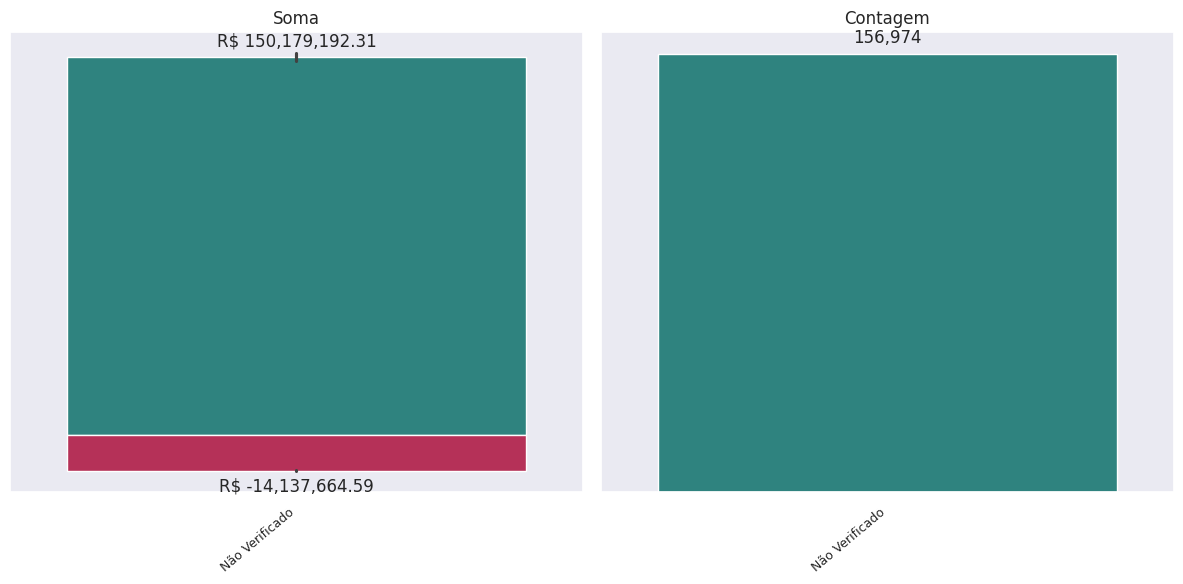

In [56]:
# Cria uma cópia do DataFrame de remuneração para controle
df_siape_remun_controle = df_siape_remun.copy()

# Chama a função plot_remun para gerar visualizações relacionadas à remuneração
plot_remun(df_siape_remun_controle)

#### 3.1.1 Identificar se o Posto/Graduação cadastrado no SIAPE é o mesmo cadastrado no GECOPE

In [57]:
# Define a condição de igualdade entre os campos "CARGO" e "dsc_posto_graduacao"
cond = df_siape_serv["CARGO"] == df_siape_serv["dsc_posto_graduacao"]

# Lista de rubricas a serem verificadas
rubricas_verificadas = [
    (82001, 0, 0),
    (82128, 0, 0),
    (82134, 0, 0),
    (82219, 0, 0),
    (82220, 0, 0),
    (82221, 0, 0),
    (82225, 0, 0),
    (82238, 0, 0),
    (82254, 0, 0),
    (82258, 0, 0),
    (82264, 0, 0),
    (82283, 0, 0),
    (82284, 0, 0),
    (82385, 0, 0),
    (82386, 0, 0),
    (82387, 0, 0),
    (82729, 0, 0),
    (82730, 0, 0),
    (83071, 0, 0),
    (98028, 0, 0),
    (98035, 0, 0),
]

# Tipo de erro associado a rubricas com postos/graduações diferentes no SIAPE e GECOPE
tipo_erro = "Posto/Graduação no SIAPE diferente do GECOPE"

In [58]:
# Chama a função verifica_rubricas para realizar a verificação e atribui os resultados ao DataFrame de controle
df_siape_remun_controle[
    ["LANCAMENTO APROVADO", "MOTIVO NAO APROVACAO","OUTLIER IDENTIFICADO"]
] = verifica_rubricas(
    cond, rubricas_verificadas, msg_err=tipo_erro, df_remun=df_siape_remun_controle
)

/tmp/ipykernel_1127/2703988988.py:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax1 = sns.barplot(
/tmp/ipykernel_1127/2703988988.py:53: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax2 = sns.barplot(
/tmp/ipykernel_1127/2703988988.py:69: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=40, ha="right", fontsize=9)
/tmp/ipykernel_1127/2703988988.py:75: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax2 = sns.countplot(
/tmp/ipykernel_1127/2703988988.py:85: UserWarning: FixedFormatter should only

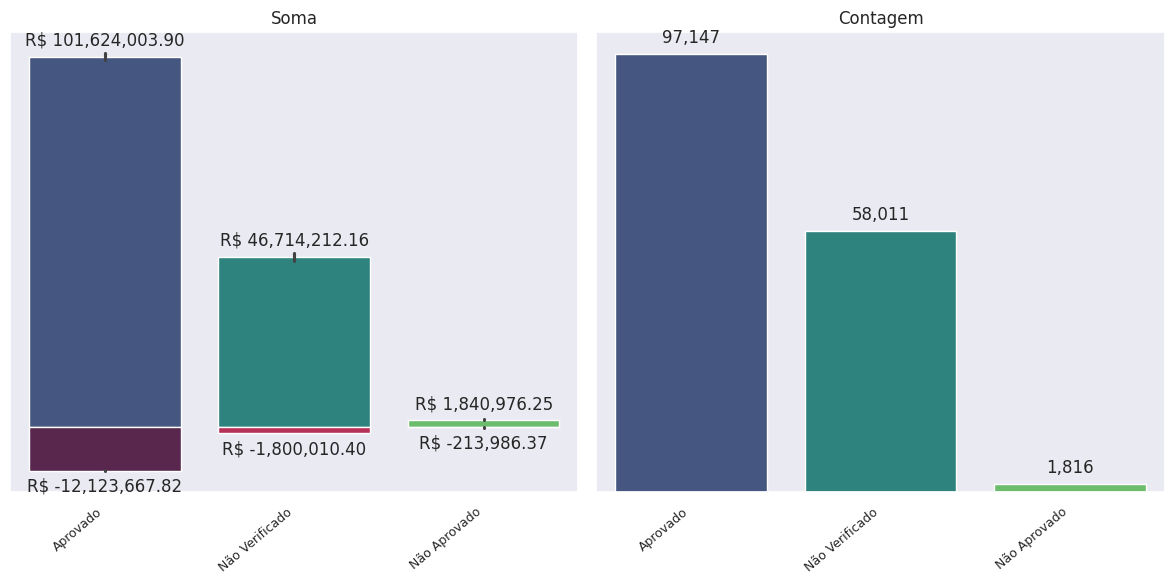

In [59]:
# Chama a função plot_remun para gerar visualizações relacionadas à remuneração
plot_remun(df_siape_remun_controle)

#### 3.1.2 Identificar se o Fundo de Saúde Adicional está sendo pago conforme a quantidade de dependentes

In [60]:
# Alinhamento dos DataFrames df_siape_serv e df_siape_remun_temp com base no índice "CPF SERVIDOR"
df_siape_serv, df_siape_remun_temp = df_siape_serv.align(
    df_siape_remun_controle[
        (df_siape_remun_controle["COD RUBRICA"] == 98036)
        & (df_siape_remun_controle["SEQUENCIAL RUBRICA"] == 1)
        & (df_siape_remun_controle["PRAZO RUBRICA"] == 0)
    ].set_index("CPF SERVIDOR"),
    join="left",
    axis=0,
)

# Condição para verificação de igualdade entre "VALOR ESPERADO FUNDO SAUDE DEP" e "LIQUIDO"
cond = df_siape_serv["VALOR ESPERADO FUNDO SAUDE DEP"] == df_siape_remun_temp["LIQUIDO"]

# Lista de rubricas a serem verificadas
rubricas_verificadas = [
    (98036, 1, 0),
]

# Tipo de erro associado à divergência nas rubricas
tipo_erro = "Fundo de Saúde Incompatível com Quantidade de Dependentes e/ou Graduação do GECOPE"

In [61]:

# Atualização das colunas "LANCAMENTO APROVADO" e "MOTIVO NAO APROVACAO" com base nas verificações
df_siape_remun_controle[
    ["LANCAMENTO APROVADO", "MOTIVO NAO APROVACAO","OUTLIER IDENTIFICADO"]
] = verifica_rubricas(
    cond, rubricas_verificadas, msg_err=tipo_erro, df_remun=df_siape_remun_controle
)

/tmp/ipykernel_1127/2703988988.py:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax1 = sns.barplot(
/tmp/ipykernel_1127/2703988988.py:53: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax2 = sns.barplot(
/tmp/ipykernel_1127/2703988988.py:69: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=40, ha="right", fontsize=9)
/tmp/ipykernel_1127/2703988988.py:75: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax2 = sns.countplot(
/tmp/ipykernel_1127/2703988988.py:85: UserWarning: FixedFormatter should only

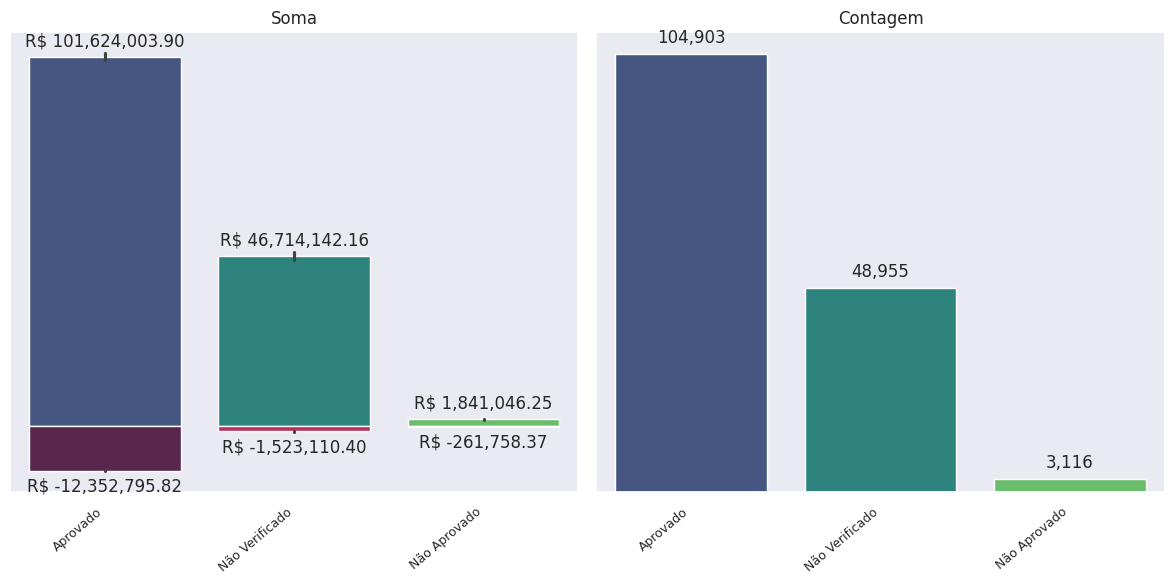

In [62]:
# Geração do gráfico para visualização das verificações
plot_remun(df_siape_remun_controle)

#### 3.1.3 Identificar se o Auxílio Moradia está de acordo com o Posto/Graduação e com a condição de dependência (Com Dependente / Sem Dependente)

In [63]:
# Alinha os DataFrames df_siape_serv e df_siape_remun_temp com base no índice "CPF SERVIDOR"
df_siape_serv, df_siape_remun_temp = df_siape_serv.align(
    df_siape_remun_controle[
        (
            (df_siape_remun_controle["COD RUBRICA"] == 82135)
            | (df_siape_remun_controle["COD RUBRICA"] == 82228)
        )
        & (df_siape_remun_controle["SEQUENCIAL RUBRICA"] == 1)
        & (df_siape_remun_controle["PRAZO RUBRICA"] == 0)
    ].set_index("CPF SERVIDOR"),
    join="left",
    axis=0,
)

# Condição para verificação: VALOR ESPERADO MORADIA deve ser igual a LIQUIDO
cond = df_siape_serv["VALOR ESPERADO MORADIA"] == df_siape_remun_temp["LIQUIDO"]

# Lista de rubricas a serem verificadas e tipo de erro associado
rubricas_verificadas = [(82135, 1, 0), (82228, 1, 0)]
tipo_erro = (
    "Auxílio Moradia Incompatível com Condição de Dependência e/ou Graduação do GECOPE"
)

In [64]:

# Atualiza as colunas "LANCAMENTO APROVADO" e "MOTIVO NAO APROVACAO" no DataFrame df_siape_remun_controle
df_siape_remun_controle[
    ["LANCAMENTO APROVADO", "MOTIVO NAO APROVACAO","OUTLIER IDENTIFICADO"]
] = verifica_rubricas(
    cond, rubricas_verificadas, msg_err=tipo_erro, df_remun=df_siape_remun_controle
)

/tmp/ipykernel_1127/2703988988.py:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax1 = sns.barplot(
/tmp/ipykernel_1127/2703988988.py:53: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax2 = sns.barplot(
/tmp/ipykernel_1127/2703988988.py:69: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=40, ha="right", fontsize=9)
/tmp/ipykernel_1127/2703988988.py:75: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax2 = sns.countplot(
/tmp/ipykernel_1127/2703988988.py:85: UserWarning: FixedFormatter should only

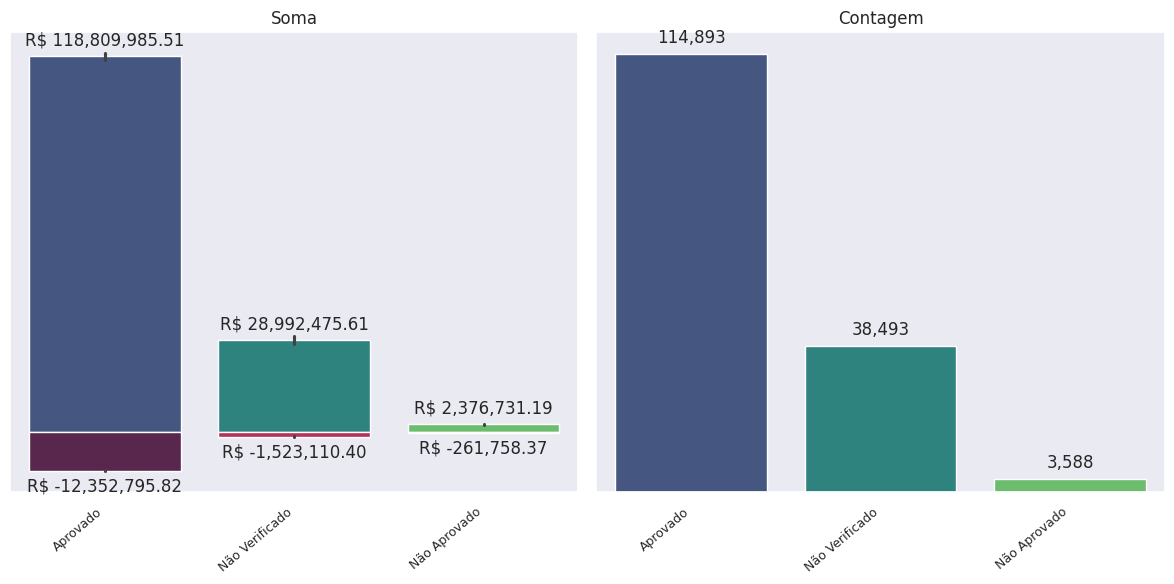

In [65]:
# Gera um gráfico para visualização das verificações
plot_remun(df_siape_remun_controle)

#### 3.1.4 Identificar se o Auxílio Alimentação está sendo pago para militares ativos ou inativos no PTTC

In [66]:
# Condição para verificação: Militar deve ser ativo (RMI-01: Ativo ou RMI-08: Cedido) ou 
# Inativo (RMI-33: Reforma ou RMI-34 Reserva) estando no PTTC (["cod_controle_status_servidor_tipo"] == 14)
cond = (
    (df_siape_serv["SITUAÇÃO FUNCIONAL"] == "RMI-01")
    | (df_siape_serv["SITUAÇÃO FUNCIONAL"] == "RMI-08")
    | (
        (
            (df_siape_serv["SITUAÇÃO FUNCIONAL"] == "RMI-33")
            | (df_siape_serv["SITUAÇÃO FUNCIONAL"] == "RMI-34")
        )
        & (df_siape_serv["cod_controle_status_servidor_tipo"] == 14)
    )
)

# Lista de rubricas a serem verificadas e tipo de erro associado
rubricas_verificadas = [(82011, 0, 0)]
tipo_erro = "Auxílio Alimentação incompatível com Status do Servidor"

In [67]:

# Atualiza as colunas "LANCAMENTO APROVADO" e "MOTIVO NAO APROVACAO" no DataFrame df_siape_remun_controle
df_siape_remun_controle[
    ["LANCAMENTO APROVADO", "MOTIVO NAO APROVACAO","OUTLIER IDENTIFICADO"]
] = verifica_rubricas(
    cond, rubricas_verificadas, msg_err=tipo_erro, df_remun=df_siape_remun_controle
)

/tmp/ipykernel_1127/2703988988.py:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax1 = sns.barplot(


/tmp/ipykernel_1127/2703988988.py:53: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax2 = sns.barplot(
/tmp/ipykernel_1127/2703988988.py:69: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=40, ha="right", fontsize=9)
/tmp/ipykernel_1127/2703988988.py:75: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax2 = sns.countplot(
/tmp/ipykernel_1127/2703988988.py:85: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(ax2.get_xticklabels(), rotation=40, ha="right", fontsize=9)


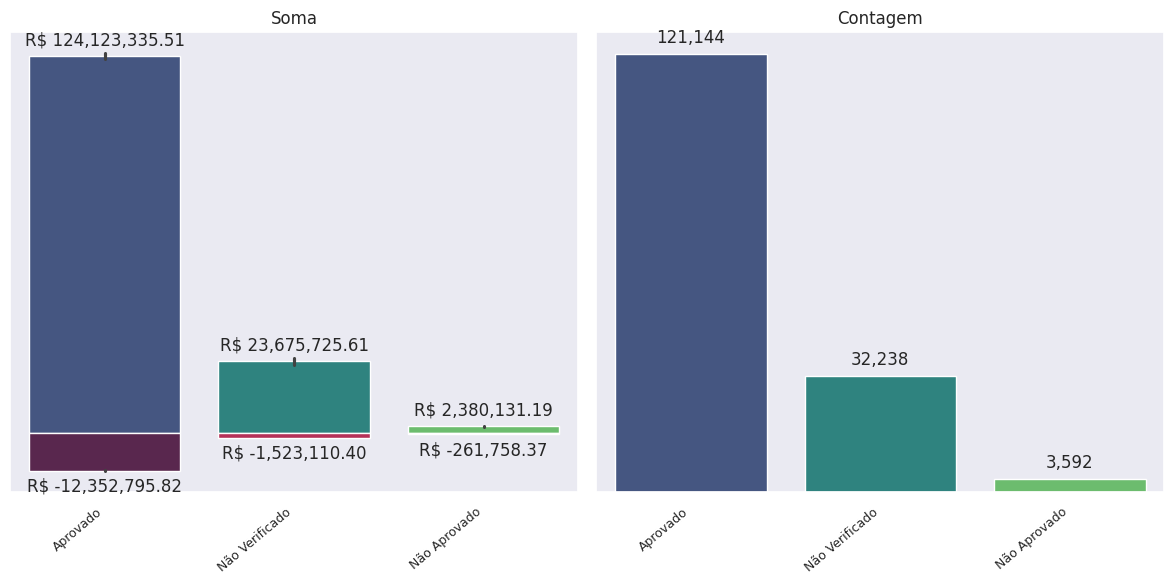

In [68]:
# Gera um gráfico para visualização das verificações
plot_remun(df_siape_remun_controle)

#### 3.1.5 Identificar se a GSV está sendo paga conforme o horário efetivo de trabalho registrado na base de dados do CBMDF

In [69]:
# Alinhamento dos DataFrames df_siape_serv e df_siape_remun_controle com base em condições específicas
df_siape_serv, df_siape_remun_temp = df_siape_serv.align(
    df_siape_remun_controle[
        (df_siape_remun_controle["COD RUBRICA"] == 82307)
        & (
            (df_siape_remun_controle["SEQUENCIAL RUBRICA"] == 1)
            | (df_siape_remun_controle["SEQUENCIAL RUBRICA"] == 1)
        )
        & (df_siape_remun_controle["PRAZO RUBRICA"] == 1)
    ].set_index("CPF SERVIDOR"),
    join="left",
    axis=0,
)

# Condição para verificação: VALOR ESPERADO GSV deve ser igual a LIQUIDO no DataFrame temporário
cond = df_siape_serv["VALOR ESPERADO GSV"] == df_siape_remun_temp["LIQUIDO"]

# Lista de rubricas a serem verificadas e tipo de erro associado
rubricas_verificadas = [
    (82307, "", 1),
]
tipo_erro = f"GSV paga é incompatível com horas cumpridas entre os dias {DATA_REFERENCIA_INICIO_FOLHA} e {DATA_REFERENCIA_TERMINO_FOLHA}"

In [70]:

# Atualiza as colunas "LANCAMENTO APROVADO" e "MOTIVO NAO APROVACAO" no DataFrame df_siape_remun_controle
df_siape_remun_controle[
    ["LANCAMENTO APROVADO", "MOTIVO NAO APROVACAO","OUTLIER IDENTIFICADO"]
] = verifica_rubricas(
    cond, rubricas_verificadas, msg_err=tipo_erro, df_remun=df_siape_remun_controle
)

/tmp/ipykernel_1127/2703988988.py:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax1 = sns.barplot(
/tmp/ipykernel_1127/2703988988.py:53: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax2 = sns.barplot(
/tmp/ipykernel_1127/2703988988.py:69: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=40, ha="right", fontsize=9)
/tmp/ipykernel_1127/2703988988.py:75: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax2 = sns.countplot(
/tmp/ipykernel_1127/2703988988.py:85: UserWarning: FixedFormatter should only

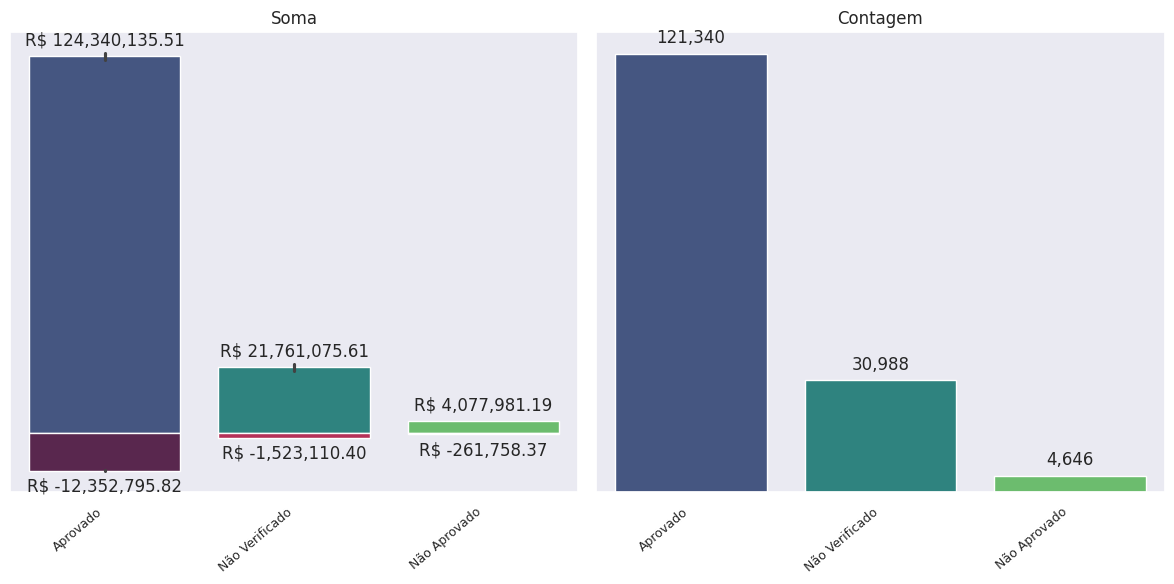

In [71]:
# Gera um gráfico para visualização das verificações
plot_remun(df_siape_remun_controle)

#### 3.1.6 Registrar necessidade de verificação manual dos pagamentos de Adicional de Certificação Profissional por não haver dados atualizados de capacitações nas base corporativa

In [72]:
# Inicialização de uma série de condições como Falso para cada índice em df_siape_serv
cond = pd.Series(False, index=df_siape_serv.index)

# Lista de rubricas a serem verificadas e tipo de erro associado
rubricas_verificadas = [
    (82235, "", ""),
    (82236, "", ""),
]
tipo_erro = "Base Corporativa sem dados atualizados de Certificação Profissional"

In [73]:

# Atualiza as colunas "LANCAMENTO APROVADO" e "MOTIVO NAO APROVACAO" no DataFrame df_siape_remun_controle
df_siape_remun_controle[
    ["LANCAMENTO APROVADO", "MOTIVO NAO APROVACAO","OUTLIER IDENTIFICADO"]
] = verifica_rubricas(
    cond, rubricas_verificadas, msg_err=tipo_erro, df_remun=df_siape_remun_controle
)

/tmp/ipykernel_1127/2703988988.py:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax1 = sns.barplot(


/tmp/ipykernel_1127/2703988988.py:53: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax2 = sns.barplot(
/tmp/ipykernel_1127/2703988988.py:69: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=40, ha="right", fontsize=9)
/tmp/ipykernel_1127/2703988988.py:75: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax2 = sns.countplot(
/tmp/ipykernel_1127/2703988988.py:85: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(ax2.get_xticklabels(), rotation=40, ha="right", fontsize=9)


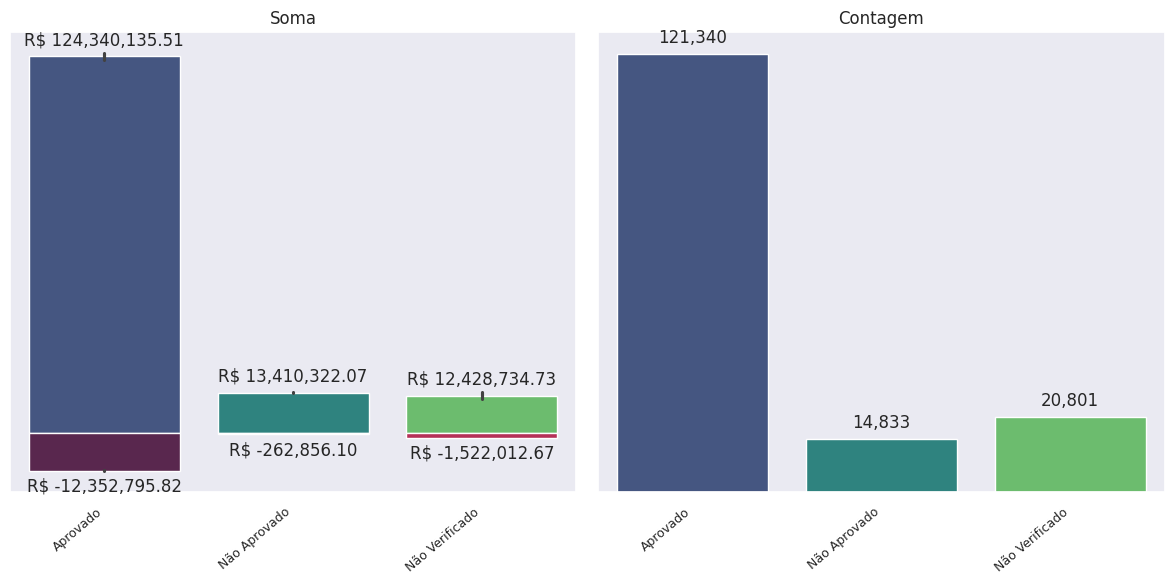

In [74]:
# Gera um gráfico para visualização das verificações
plot_remun(df_siape_remun_controle)




### 3.2 Abordagem pontual: identificação de outliers

#### 3.2.1 Identificar se foi pago Auxílio Natalidade com prazo diferente de 1

In [75]:
# Inicialização de uma série de condições como Falso para cada índice em df_siape_serv
cond = (
    (df_siape_remun_controle["PRAZO RUBRICA"]
    != 1) & (df_siape_remun_controle["COD RUBRICA"]
    == 82265)
)

# Lista de rubricas a serem verificadas e tipo de erro associado
rubricas_verificadas = [(82265, "", "")]
tipo_erro = "Auxílio Natalidade pago em mais de uma parcela"

In [76]:

# Atualiza as colunas "LANCAMENTO APROVADO" e "MOTIVO NAO APROVACAO" no DataFrame df_siape_remun_controle
df_siape_remun_controle[
    ["LANCAMENTO APROVADO", "MOTIVO NAO APROVACAO","OUTLIER IDENTIFICADO"]
] = verifica_rubricas(
    cond, rubricas_verificadas, msg_err=tipo_erro, df_remun=df_siape_remun_controle, df_condition_reference=df_siape_remun_controle,column_condition_reference="CPF SERVIDOR",outlier=True
)

/tmp/ipykernel_1127/2703988988.py:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax1 = sns.barplot(
/tmp/ipykernel_1127/2703988988.py:53: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax2 = sns.barplot(
/tmp/ipykernel_1127/2703988988.py:69: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=40, ha="right", fontsize=9)
/tmp/ipykernel_1127/2703988988.py:75: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax2 = sns.countplot(
/tmp/ipykernel_1127/2703988988.py:85: UserWarning: FixedFormatter should only

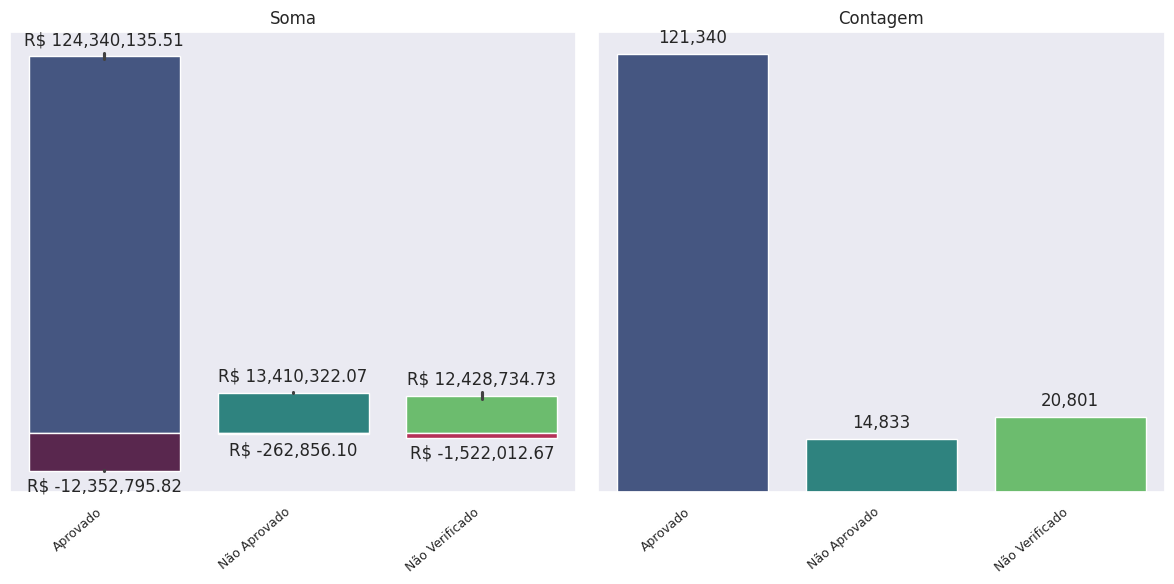

In [77]:
# Gera um gráfico para visualização das verificações
plot_remun(df_siape_remun_controle)

#### 3.2.2 Identificar se foi pago GSV com prazo diferente de 1

In [78]:
# Inicialização de uma série de condições como Falso para cada índice em df_siape_serv
cond = (df_siape_remun_controle["PRAZO RUBRICA"] != 1) & (
    df_siape_remun_controle["COD RUBRICA"] == 82307
)

# Lista de rubricas a serem verificadas e tipo de erro associado
rubricas_verificadas = [(82307, "", "")]
tipo_erro = "GSV paga em mais de uma parcela"

In [79]:

# Atualiza as colunas "LANCAMENTO APROVADO" e "MOTIVO NAO APROVACAO" no DataFrame df_siape_remun_controle
df_siape_remun_controle[
    ["LANCAMENTO APROVADO", "MOTIVO NAO APROVACAO","OUTLIER IDENTIFICADO"]
] = verifica_rubricas(
    cond, rubricas_verificadas, msg_err=tipo_erro, df_remun=df_siape_remun_controle, df_condition_reference=df_siape_remun_controle,column_condition_reference="CPF SERVIDOR",outlier=True
)

/tmp/ipykernel_1127/2703988988.py:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax1 = sns.barplot(
/tmp/ipykernel_1127/2703988988.py:53: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax2 = sns.barplot(
/tmp/ipykernel_1127/2703988988.py:69: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=40, ha="right", fontsize=9)
/tmp/ipykernel_1127/2703988988.py:75: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax2 = sns.countplot(
/tmp/ipykernel_1127/2703988988.py:85: UserWarning: FixedFormatter should only

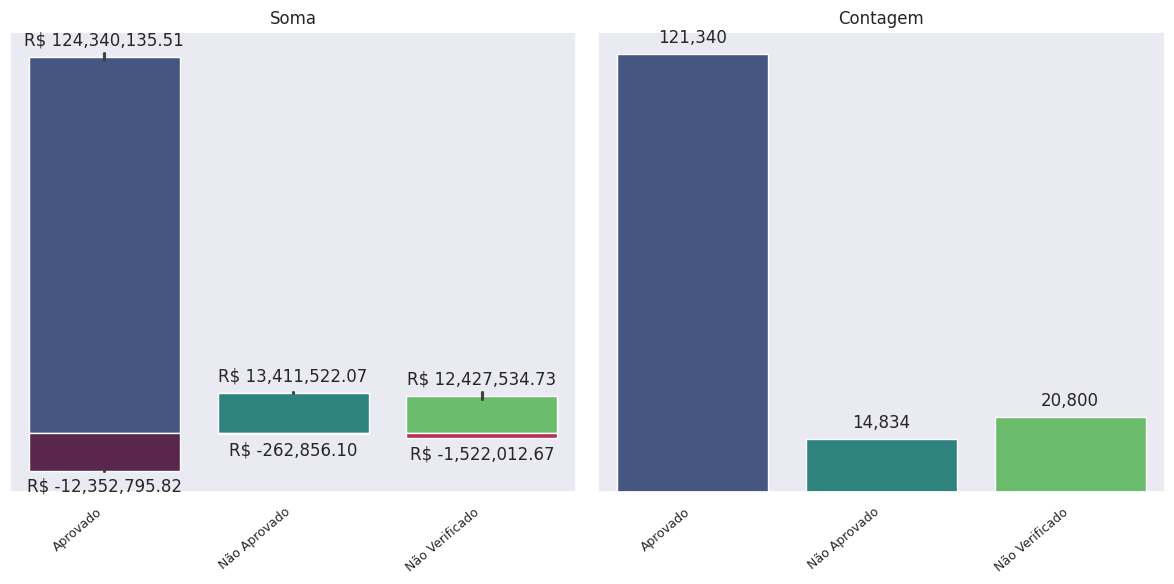

In [80]:
# Gera um gráfico para visualização das verificações
plot_remun(df_siape_remun_controle)

#### 3.2.3 Identificar se foi pago indenização por Transferência para RRm com prazo diferente de 1

In [81]:
# Inicialização de uma série de condições como Falso para cada índice em df_siape_serv
cond = ((df_siape_remun_controle["PRAZO RUBRICA"] != 1) & (
    (df_siape_remun_controle["COD RUBRICA"] == 82735)
    | (df_siape_remun_controle["COD RUBRICA"] == 505)
    | (df_siape_remun_controle["COD RUBRICA"] == 82266)
))

# Lista de rubricas a serem verificadas e tipo de erro associado
rubricas_verificadas = [
    (82735, "", ""),
    (505, "", ""),
    (82266, "", ""),
]
tipo_erro = "Indenização por transferência para RRm paga em mais de uma parcela"

In [82]:

# Atualiza as colunas "LANCAMENTO APROVADO" e "MOTIVO NAO APROVACAO" no DataFrame df_siape_remun_controle
df_siape_remun_controle[
    ["LANCAMENTO APROVADO", "MOTIVO NAO APROVACAO","OUTLIER IDENTIFICADO"]
] = verifica_rubricas(
    cond, rubricas_verificadas, msg_err=tipo_erro, df_remun=df_siape_remun_controle, df_condition_reference=df_siape_remun_controle,column_condition_reference="CPF SERVIDOR",outlier=True
)

/tmp/ipykernel_1127/2703988988.py:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax1 = sns.barplot(
/tmp/ipykernel_1127/2703988988.py:53: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax2 = sns.barplot(
/tmp/ipykernel_1127/2703988988.py:69: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=40, ha="right", fontsize=9)
/tmp/ipykernel_1127/2703988988.py:75: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax2 = sns.countplot(
/tmp/ipykernel_1127/2703988988.py:85: UserWarning: FixedFormatter should only

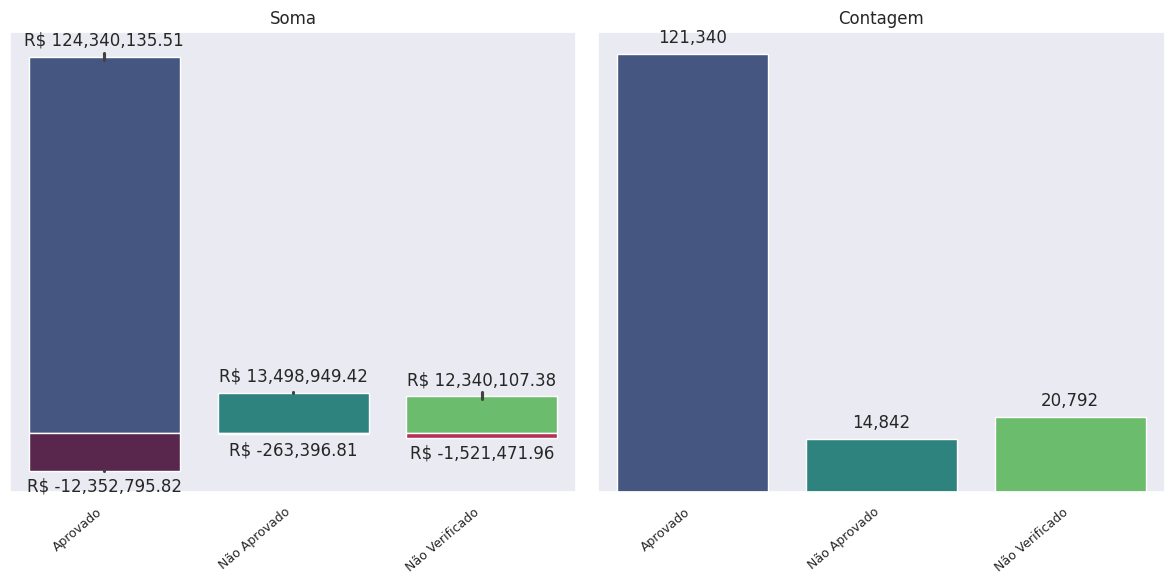

In [83]:
# Gera um gráfico para visualização das verificações
plot_remun(df_siape_remun_controle)

/tmp/ipykernel_1127/2703988988.py:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax1 = sns.barplot(
/tmp/ipykernel_1127/2703988988.py:53: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax2 = sns.barplot(
/tmp/ipykernel_1127/2703988988.py:69: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=40, ha="right", fontsize=9)
/tmp/ipykernel_1127/2703988988.py:75: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax2 = sns.countplot(
/tmp/ipykernel_1127/2703988988.py:85: UserWarning: FixedFormatter should only

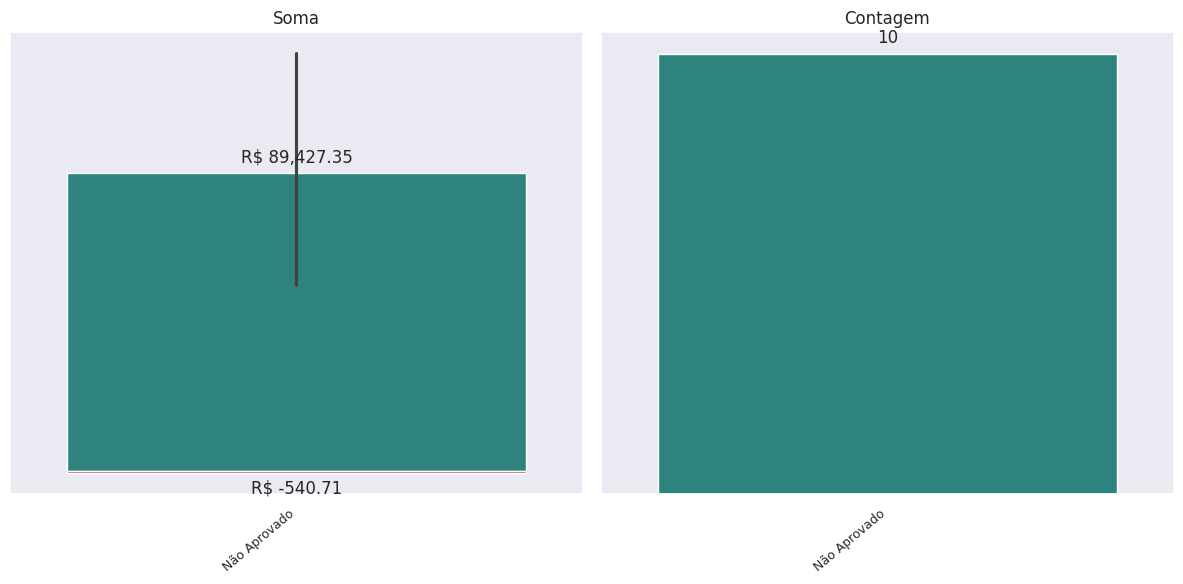

In [84]:
plot_remun(df_siape_remun_controle[df_siape_remun_controle["OUTLIER IDENTIFICADO"]])

### 3.3 Geração do Relatório de Controle de Folha

In [85]:
# Geração de arquivo .csv para complementação da verificação dos valores
df_siape_remun_controle.to_csv(
    f"./relatorioMensal - {MES_REFERENCIA}.csv",
    sep=";",
    encoding="iso-8859-1",
    decimal=",",
    index=False,
)

/tmp/ipykernel_1127/2703988988.py:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax1 = sns.barplot(
/tmp/ipykernel_1127/2703988988.py:53: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax2 = sns.barplot(
/tmp/ipykernel_1127/2703988988.py:69: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=40, ha="right", fontsize=9)
/tmp/ipykernel_1127/2703988988.py:75: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax2 = sns.countplot(
/tmp/ipykernel_1127/2703988988.py:85: UserWarning: FixedFormatter should only

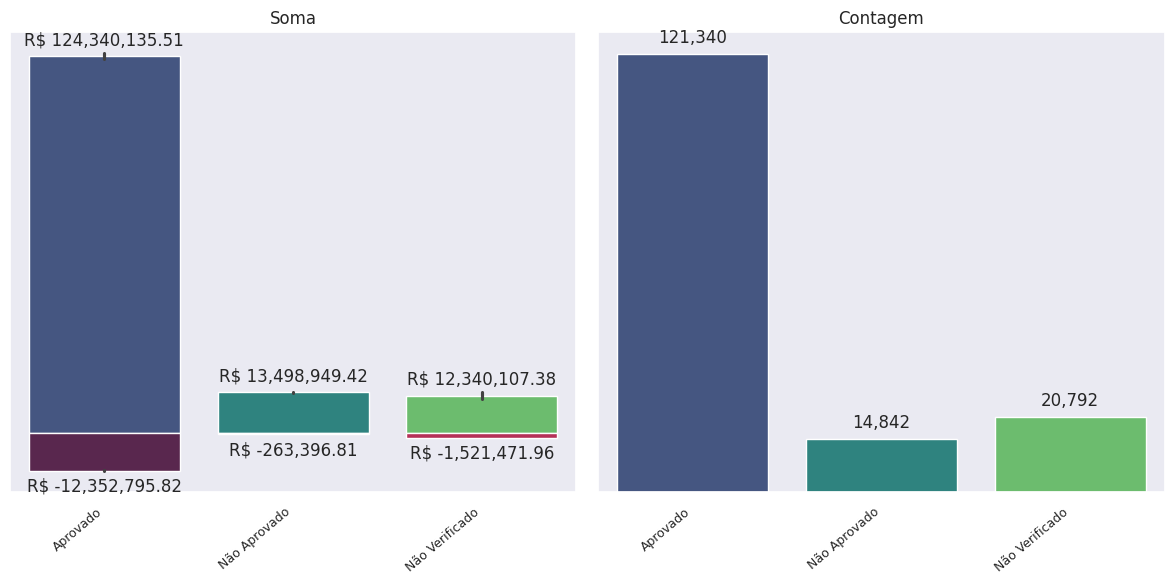

In [86]:
# Gráfico contendo resumo dos valores analisados
plot_remun(
    df_siape_remun_controle[
        (df_siape_remun_controle["LANCAMENTO APROVADO"] == True)
        | (df_siape_remun_controle["LANCAMENTO APROVADO"] == False)
        | (df_siape_remun_controle["LANCAMENTO APROVADO"].isnull())
    ]
)